# Hello, Numerai

Hello and welcome to the Numerai Data Science Tournament!

This notebook is designed to help you build your first machine learning model and start competing the tournament.

In this notebook we will
1. Download and explore the Numerai dataset
2. Train and evaluate your first machine learning model
3. Deploy your model to start making live submissions

In [1]:
!python --version

Python 3.12.12


In [2]:
# Install dependencies
!pip install -q --upgrade numerapi pandas pyarrow matplotlib lightgbm scikit-learn scipy cloudpickle==3.1.1

# Inline plots
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 16.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 3.0.0 which is incompatible.
bqplot 0.12.45 requires pandas<3.0.0,>=1.0.0, but you have pandas 3.0.0 which is incompatible.
cudf-

## 1. Dataset  

At a high level, the Numerai dataset is a tabular dataset that describes the stock market over time. It is compiled from high-quality (and expensive) data that might be difficult for individuals to obtain.

The unique thing about Numerai's dataset is that it is `obfuscated`, which means that the underlying stock ids, feature names, and target definitions are anonymized. This makes it so that we can give this data out for free and so that it can be modeled without any financial domain knowledge (or bias!).

### Listing the datasets
Firstly, take a look at the files Numerai offers below:

In [3]:
# Initialize NumerAPI - the official Python API client for Numerai
from numerapi import NumerAPI
napi = NumerAPI()

# list the datasets and available versions
all_datasets = napi.list_datasets()
dataset_versions = list(set(d.split('/')[0] for d in all_datasets))
print("Available versions:\n", dataset_versions)

# Set data version to one of the latest datasets
DATA_VERSION = "v5.2"

# Print all files available for download for our version
current_version_files = [f for f in all_datasets if f.startswith(DATA_VERSION)]
print("Available", DATA_VERSION, "files:\n", current_version_files)

Available versions:
 ['v5.0', 'v5.1', 'v5.2']
Available v5.2 files:
 ['v5.2/features.json', 'v5.2/live.parquet', 'v5.2/live_benchmark_models.parquet', 'v5.2/live_example_preds.csv', 'v5.2/live_example_preds.parquet', 'v5.2/meta_model.parquet', 'v5.2/train.parquet', 'v5.2/train_benchmark_models.parquet', 'v5.2/validation.parquet', 'v5.2/validation_benchmark_models.parquet', 'v5.2/validation_example_preds.csv', 'v5.2/validation_example_preds.parquet']


### Downloading datasets

The `features.json` file contains metadata about features in the dataset including:
- statistics on each feature
- helpful sets of features
- the targets available for training

Let's download it and take a look:

In [4]:
import json

# download the feature metadata file
napi.download_dataset(f"{DATA_VERSION}/features.json")

# read the metadata and display
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
for metadata in feature_metadata:
  print(metadata, len(feature_metadata[metadata]))

v5.2/features.json: 324kB [00:00, 629kB/s]                           

feature_sets 18
targets 41


### Feature Sets & Groups
As you can see there are many features and targets to choose from.

Instead of training a model on all 2000+ features, let's pick a subset of features to analyze.

Here are a few starter sets Numerai offers:

- `small` contains a minimal subset of features that have the highest [feature importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

- `medium` contains all the "basic" features, each unique in some way (e.g. P/E ratios vs analyst ratings)

- `all` contains all features in `medium` and their variants (e.g. P/E by country vs P/E by sector)

Let's take a look at the medium feature set:

In [5]:
feature_sets = feature_metadata["feature_sets"]
for feature_set in ["small", "medium", "all"]:
  print(feature_set, len(feature_sets[feature_set]))

small 42
medium 780
all 2748



The `medium` set seems much more reasonable.

Using it will speed up model training and reduce memory usage (required for Colab free tier).

Let's load the training data for just the medium feature set:

In [6]:
import pandas as pd

# Define our feature set
feature_set = feature_sets["small"]
# use "medium" or "all" for better performance. Requires more RAM.
# features = feature_metadata["feature_sets"]["medium"]
# features = feature_metadata["feature_sets"]["all"]

# Download the training data - this will take a few minutes
napi.download_dataset(f"{DATA_VERSION}/train.parquet")

# Load only the "medium" feature set to
# Use the "all" feature set to use all features
train = pd.read_parquet(
    f"{DATA_VERSION}/train.parquet",
    columns=["era", "target"] + feature_set
)

# Downsample to every 4th era to reduce memory usage and speedup model training (suggested for Colab free tier)
# Comment out the line below to use all the data
train = train[train["era"].isin(train["era"].unique()[::4])]

v5.2/train.parquet: 2.57GB [03:09, 13.6MB/s]                            



### Training data

Each row represents a stock at a specific point in time:
- `id` is the stock id
- `era` is the date
- `target` is a measure of future returns for that stock
- `features` describe the attributes of the stock (eg. P/E ratio) for that date

In [ ]:
train

,era,target,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,...,feature_tridactyl_immoral_snorting,feature_trimeter_soggy_greatest,feature_unanalyzable_excusable_whirlwind,feature_unbreakable_constraining_hegelianism,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute
id,,,,,,,,,,,,,,,,,,,,,
n0007b5abb0c3a25,0001,0.25,2,2,2,2,2,0,1,2,...,4,1,1,3,0,2,2,3,3,2
n003bba8a98662e4,0001,0.50,2,2,2,2,2,1,4,2,...,4,2,0,0,0,2,2,4,4,2
n003bee128c2fcfc,0001,1.00,2,2,2,2,2,2,2,2,...,3,1,1,0,1,2,2,0,3,2
n0048ac83aff7194,0001,0.25,2,2,2,2,2,1,4,2,...,1,3,4,1,2,2,2,2,0,2
n0055a2401ba6480,0001,0.50,2,2,2,2,2,0,0,2,...,1,0,1,0,0,2,2,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffc2d5e4b79a7ae,0573,0.25,1,2,1,0,3,2,1,1,...,2,2,1,2,3,3,3,2,2,1
nffc9844c1c7a6a9,0573,0.50,2,1,2,1,4,2,2,4,...,4,0,0,3,1,3,3,2,3,2
nffd79773f4109bb,0573,0.50,3,4,0,3,4,1,0,1,...,3,0,0,0,1,1,4,0,1,2


### Eras
As mentioned above, each `era` corresponds to a different date. Each era is exactly 1 week apart.

It is helpful to think about rows of stocks within the same `era` as a single example. You will notice that throughout this notebook and other examples, we often talk about things "per era". For example, the number of rows per era represents the number of stocks in Numerai's investable universe on that date.

<Axes: title={'center': 'Number of rows per era'}, xlabel='Era'>

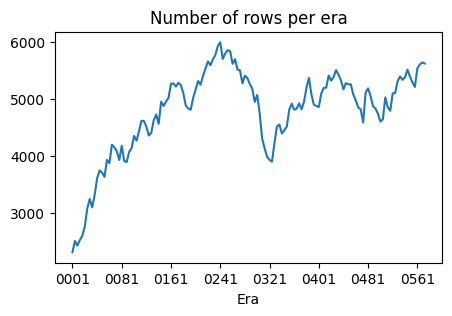

In [7]:
# Plot the number of rows per era
train.groupby("era").size().plot(
    title="Number of rows per era",
    figsize=(5, 3),
    xlabel="Era"
)

### Target
The `target` is a measure of stock market returns over the next 20 (business) days. Specifically, it is a measure of "stock-specific" returns that are not explained by well-known "factors" or broader trends in the market, country, or sector. For example, if Apple went up and the tech sector also went up, we only want to know if Apple went up more or less than the tech sector.

Target values are binned into 5 unequal bins: `0`, `0.25`, `0.5`, `0.75`, `1.0`. Again, this heavy regularization of target values is to avoid overfitting as the underlying values are extremely noisy.

<Axes: title={'center': 'Target'}, xlabel='Value', ylabel='Frequency'>

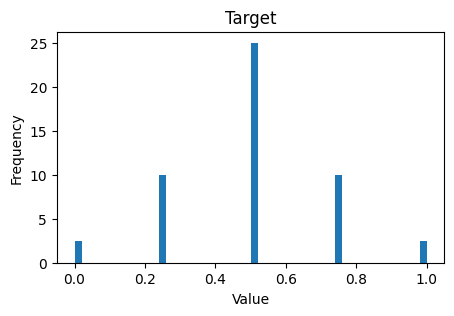

In [8]:
# Plot density histogram of the target
train["target"].plot(
  kind="hist",
  title="Target",
  figsize=(5, 3),
  xlabel="Value",
  density=True,
  bins=50
)

### Features
The `features` are quantitative attributes of each stock: fundamentals like P/E ratio, technical signals like RSI, market data like short interest, secondary data like analyst ratings, and much more.

The underlying definition of each feature is not important, just know that Numerai has included these features in the dataset because we believe they are predictive of the `target` either by themselves or in combination with other features.

Feature values are binned into 5 equal bins: `0`, `1`, `2`, `3`, `4`. This heavy regularization of feature values is to avoid overfitting as the underlying values are extremely noisy. Unlike the target, these are integers instead of floats to reduce the storage needs of the overall dataset.

If data for a particular feature is missing for that era (more common in early `eras`), then all values will be set to `2`.

<Axes: title={'center': 'missing data'}, ylabel='Frequency'>

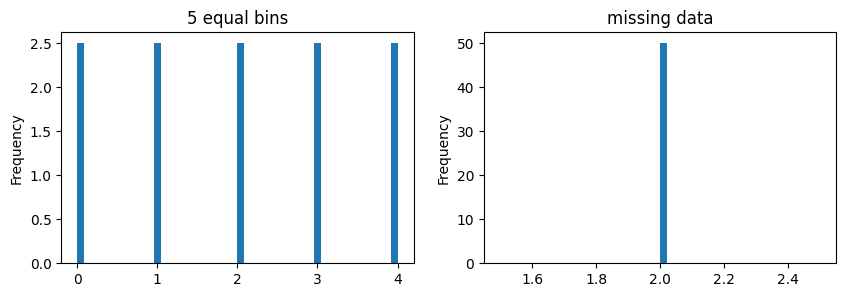

In [9]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
first_era = train[train["era"] == train["era"].unique()[0]]
last_era = train[train["era"] == train["era"].unique()[-1]]
last_era[feature_set[-1]].plot(
   title="5 equal bins",
   kind="hist",
   density=True,
   bins=50,
   ax=ax1
)
first_era[feature_set[-1]].plot(
   title="missing data",
   kind="hist",
   density=True,
   bins=50,
   ax=ax2
)

## 2. Modeling
At a high level, our task is to model and predict the `target` using the `features`.

### Model training

You are free to use any tool or framework, but here we will be using LGBMRegressor, a popular choice amongst tournament participants. While you wait for the model to train, watch this [video](https://www.youtube.com/watch?v=w8Y7hY05z7k) to learn why tree-based models work so well on tabular datasets from our Chief Scientist MDO.

In [10]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
import lightgbm as lgb

# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
model = lgb.LGBMRegressor(
  n_estimators=2000,
  learning_rate=0.01,
  max_depth=5,
  num_leaves=2**5-1,
  colsample_bytree=0.1
)
# We've found the following "deep" parameters perform much better, but they require much more CPU and RAM
# model = lgb.LGBMRegressor(
#     n_estimators=30_000,
#     learning_rate=0.001,
#     max_depth=10,
#     num_leaves=2**10,
#     colsample_bytree=0.1
#     min_data_in_leaf=10000,
# )

# This will take a few minutes 🍵
model.fit(
  train[feature_set],
  train["target"]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 688182, number of used features: 42
[LightGBM] [Info] Start training from score 0.499948


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.01
,n_estimators,2000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


### Validation predictions

Now let's make some out-of-sample predictions on the validation dataset to evaluate our model's performance.

In [11]:
# Download validation data - this will take a few minutes
napi.download_dataset(f"{DATA_VERSION}/validation.parquet")

# Load the validation data and filter for data_type == "validation"
validation = pd.read_parquet(
    f"{DATA_VERSION}/validation.parquet",
    columns=["era", "data_type", "target"] + feature_set
)
validation = validation[validation["data_type"] == "validation"]
del validation["data_type"]

# Downsample to every 4th era to reduce memory usage and speedup evaluation (suggested for Colab free tier)
# Comment out the line below to use all the data (slower and higher memory usage, but more accurate evaluation)
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

# Eras are 1 week apart, but targets look 20 days (o 4 weeks/eras) into the future,
# so we need to "embargo" the first 4 eras following our last train era to avoid "data leakage"
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

# Generate predictions against the out-of-sample validation features
# This will take a few minutes 🍵
validation["prediction"] = model.predict(validation[feature_set])
validation[["era", "prediction", "target"]]

v5.2/validation.parquet: 4.13GB [06:06, 11.3MB/s]                            


,era,prediction,target
id,,,
n000c290e4364875,0579,0.495435,0.50
n002a15bc5575bbb,0579,0.508175,0.25
n00309caaa0f955e,0579,0.504713,0.75
n0039cbdcf835708,0579,0.511593,0.50
n004143458984f89,0579,0.492420,0.50
...,...,...,...
nffdc6782c68ad86,1199,0.502465,0.50
nffe7d232083310e,1199,0.498179,0.75
nfff0aa4aadeb1d4,1199,0.490295,0.25


### Performance evaluation

Numerai calculates scores designed to "align incentives" between your model and the hedge fund - a model with good scores should help the hedge fund make good returns. The primary scoring metrics in Numerai are:

- `CORR` (or "Correlation") which is calculated by the function `numerai_corr` - a Numerai specific variant of the Pearson Correlation between your model and the target.

- `MMC` (or "Meta Model Contribution") which is a calculated by the function `correlation_contribution` - a measure of how uniquely additive your model is to the Numerai Meta Model.

On the Numerai website you will see `CORR` referred to as `CORR20V2`, where the "20" refers to the 20-day return target and "v2" specifies that we are using the 2nd version of the scoring function.

In [12]:
# install Numerai's open-source scoring tools
!pip install -q --no-deps numerai-tools

# import the 2 scoring functions
from numerai_tools.scoring import numerai_corr, correlation_contribution

# Download and join in the meta_model for the validation eras
napi.download_dataset(f"v4.3/meta_model.parquet", round_num=842)
validation["meta_model"] = pd.read_parquet(
    f"v4.3/meta_model.parquet"
)["numerai_meta_model"]

v4.3/meta_model.parquet: 29.0MB [00:03, 7.75MB/s]                            


As mentioned above, it is important for us to score each historical `era` independantly. So when evaluating the performance of our model, we should be looking at the "per era" metrics.

One thing you may notice here is how low the scores are (in the range of +/- 0.05). This is very normal in the domain of quantitative finance and is part of the reason why we say Numerai is the "hardest data science tournament" in the world.

<Axes: title={'center': 'Validation MMC'}, xlabel='era'>

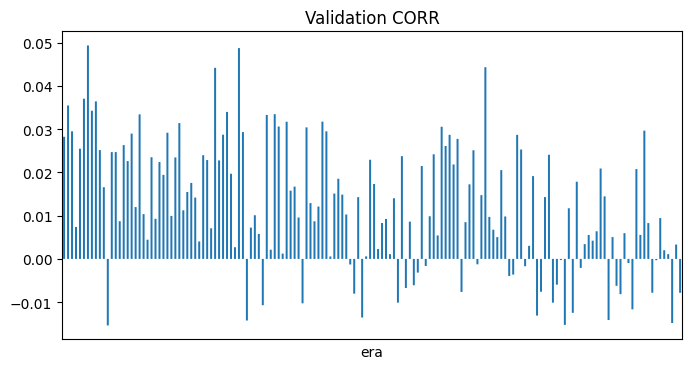

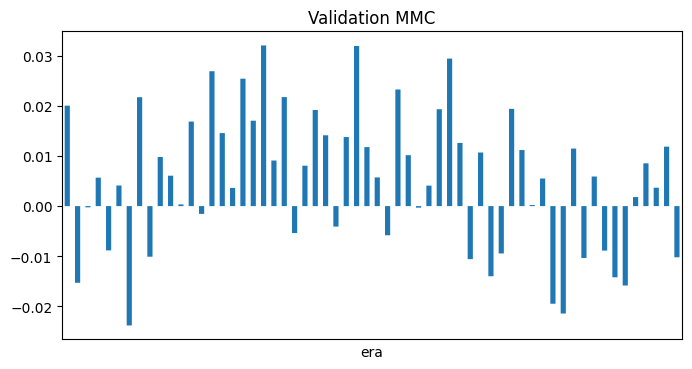

In [13]:
# Compute the per-era corr between our predictions and the target values
per_era_corr = validation.groupby("era").apply(
    lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna())
)

# Compute the per-era mmc between our predictions, the meta model, and the target values
per_era_mmc = validation.dropna().groupby("era").apply(
    lambda x: correlation_contribution(x[["prediction"]], x["meta_model"], x["target"])
)


# Plot the per-era correlation
per_era_corr.plot(
  title="Validation CORR",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)
per_era_mmc.plot(
  title="Validation MMC",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)

Instead of looking at the raw score for each era, it is helpful to look at the cumulative scores.

If you are familiar with "backtesting" in quant finance where people simulate the historical performance of their investment strategies, you can roughly think of this plot as a backtest of your model performance over the historical validation period.

Notice a few things below:

- CORR gradually increases over many eras of the validation data even with this simple model on modern data.

- MMC is generated over a smaller set of recent eras - this is because the validation time range pre-dates the Meta Model.

- MMC is very high early on in the Meta Model's existence, MMC - this is because the newest datasets were not available and models trained on the newest data are could have been very additive in the past.

- MMC is flat and decreasing recently because the Meta Model has started catching up to modern data sets and getting correlation has been difficult in recent eras.

<Axes: title={'center': 'Cumulative Validation MMC'}, xlabel='era'>

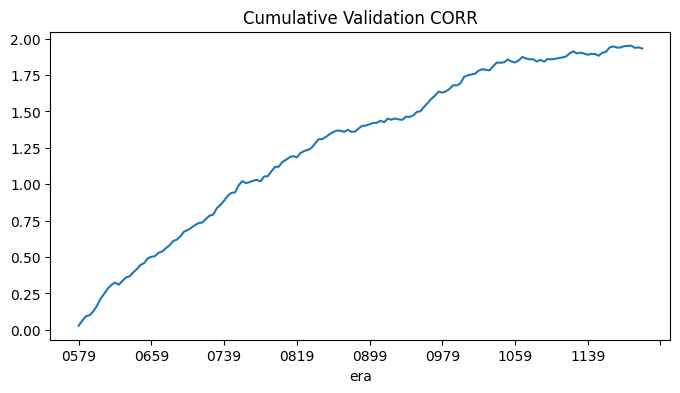

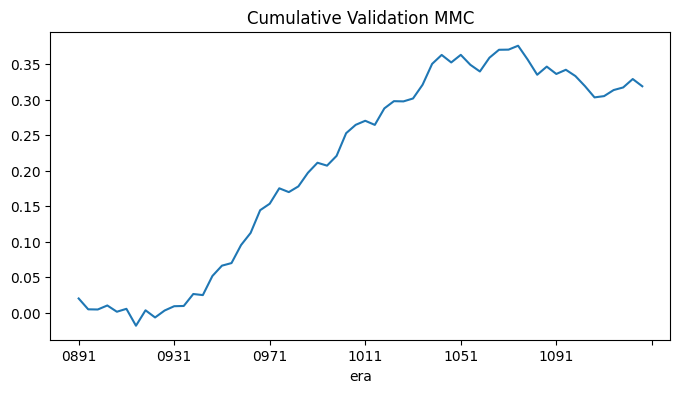

In [14]:
# Plot the cumulative per-era correlation
per_era_corr.cumsum().plot(
  title="Cumulative Validation CORR",
  kind="line",
  figsize=(8, 4),
  legend=False
)
per_era_mmc.cumsum().plot(
  title="Cumulative Validation MMC",
  kind="line",
  figsize=(8, 4),
  legend=False
)

### Performance metrics

To evaluate the performance of our model, it is also helpful to compute some summary metrics over the entire validation period:

- `Mean` is the primary measure of your model's long-term performance.

- `Sharpe` is a measure of your model's consistency. In finance, the Sharpe ratio of an investment strategy measures risk adjusted returns. In Numerai, we compute sharpe as the mean divided by the standard deviation.

- `Max drawdown` is a measure of your model's risk. In finance, the max drawdown of an investment strategy is the largest loss suffered. In Numerai, we compute max drawdown as the maximum peak to trough drop in a cumulative score.

In [15]:
# Compute performance metrics
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

mmc_mean = per_era_mmc.mean()
mmc_std = per_era_mmc.std(ddof=0)
mmc_sharpe = mmc_mean / mmc_std
mmc_max_drawdown = (per_era_mmc.cumsum().expanding(min_periods=1).max() - per_era_mmc.cumsum()).max()

pd.DataFrame({
    "mean": [corr_mean, mmc_mean],
    "std": [corr_std, mmc_std],
    "sharpe": [corr_sharpe, mmc_sharpe],
    "max_drawdown": [corr_max_drawdown, mmc_max_drawdown]
}, index=["CORR", "MMC"]).T

,CORR,MMC
mean,prediction 0.012383 dtype: float64,prediction 0.005311 dtype: float64
std,prediction 0.014719 dtype: float64,prediction 0.013693 dtype: float64
sharpe,prediction 0.841273 dtype: float64,prediction 0.387854 dtype: float64
max_drawdown,prediction 0.032358 dtype: float64,prediction 0.072722 dtype: float64


These performance metrics above are not amazing but that's ok, we are just getting started. In the next few tutorials, you will learn how to improve our model performance.

## 3. Submissions

Unlike Kaggle competitions that evalute models based on <ins>test</ins> performance, Numerai evaluates models based based on <ins>live</ins> performance.

### Live predictions

Every Tuesday-Saturday, new `live features` are released, which represent the current state of the stock market.

Your task is to generate `live predictions` on the unknown target values, which represent stock market returns 20 days into the future.

In [16]:
# Download latest live features
napi.download_dataset(f"{DATA_VERSION}/live.parquet")

# Load live features
live_features = pd.read_parquet(f"{DATA_VERSION}/live.parquet", columns=feature_set)

# Generate live predictions
live_predictions = model.predict(live_features[feature_set])

# Format submission
pd.Series(live_predictions, index=live_features.index).to_frame("prediction")

v5.2/live.parquet: 9.97MB [00:01, 5.69MB/s]                            


,prediction
id,
n00034d7a8efa8d1,0.494959
n000a5c2bcfb6784,0.495429
n000ede9d60cd9e4,0.501130
n00131ef47c822e1,0.496184
n00554b65fa33edd,0.505574
...,...
nffea70e312db6e2,0.502727
nffee527d6ac688e,0.494558
nffefba5df755dd9,0.502894


### Model upload

To participate in the tournament, you must submit live predictions every Tuesday-Saturday.

To automate this process, you can simply:
- Define your prediction pipeline as a function
- Serialize your function using the `cloudpickle` library
- Upload your model pickle file to Numerai
- Let Numerai run your model to submit live predictions every day

Read more about Model Uploads and other self-hosted automation options in our [docs](https://docs.numer.ai/numerai-tournament/submissions#automation).


In [17]:
# Define your prediction pipeline as a function
def predict(live_features: pd.DataFrame) -> pd.DataFrame:
    live_predictions = model.predict(live_features[feature_set])
    submission = pd.Series(live_predictions, index=live_features.index)
    return submission.to_frame("prediction")

In [18]:
# Use the cloudpickle library to serialize your function
import cloudpickle
p = cloudpickle.dumps(predict)
with open("hello_numerai.pkl", "wb") as f:
    f.write(p)

In [19]:
# Download file if running in Google Colab
try:
    from google.colab import files
    files.download('hello_numerai.pkl')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

That's it! You now have a pickle file that is ready for upload.

Head back to the [Hello Numerai Tutorial](https://numer.ai/tutorial/hello-numerai) to upload your model!